# Colinealidad y desempeño de modelos

## 1. Carga del dataset

In [12]:
import pandas as pd

# Cargar el dataset original
ruta    = "Lol2024.xlsx"
df      = pd.read_excel(ruta)

# Columnas a eliminar
modified_cols_drop = [
    "matchId", "blueWin",
    "redTeamControlWardsPlaced", "redTeamWardsPlaced", "redTeamTotalKills",
    "redTeamDragonKills", "redTeamHeraldKills", "redTeamTowersDestroyed",
    "redTeamInhibitorsDestroyed", "redTeamTurretPlatesDestroyed",
    "redTeamMinionsKilled", "redTeamJungleMinions", "redTeamTotalGold",
    "redTeamXp", "redTeamTotalDamageToChamps"
]

# Limpiar posibles espacios en los nombres
modified_cols_drop = [c.strip() for c in modified_cols_drop]

presentes = [c for c in modified_cols_drop if c in df.columns]
faltantes = [c for c in modified_cols_drop if c not in df.columns]

# Eliminar columnas presentes
df_clean = df.drop(columns=presentes, errors="ignore")

df_clean.head()

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,blueTeamJungleMinions,blueTeamTotalGold,blueTeamXp,blueTeamTotalDamageToChamps
0,2,23,4,2,0,0,0,7,0,388,106,23923,29798,21842
1,2,46,12,1,0,1,0,10,0,348,98,27852,30530,35817
2,2,19,13,0,0,0,0,11,0,331,96,28126,29501,38039
3,3,28,8,0,1,1,0,9,1,355,84,27333,30466,31338
4,3,30,11,1,1,1,0,7,0,370,100,27772,31066,26676


## 1.1. Matriz de correlación

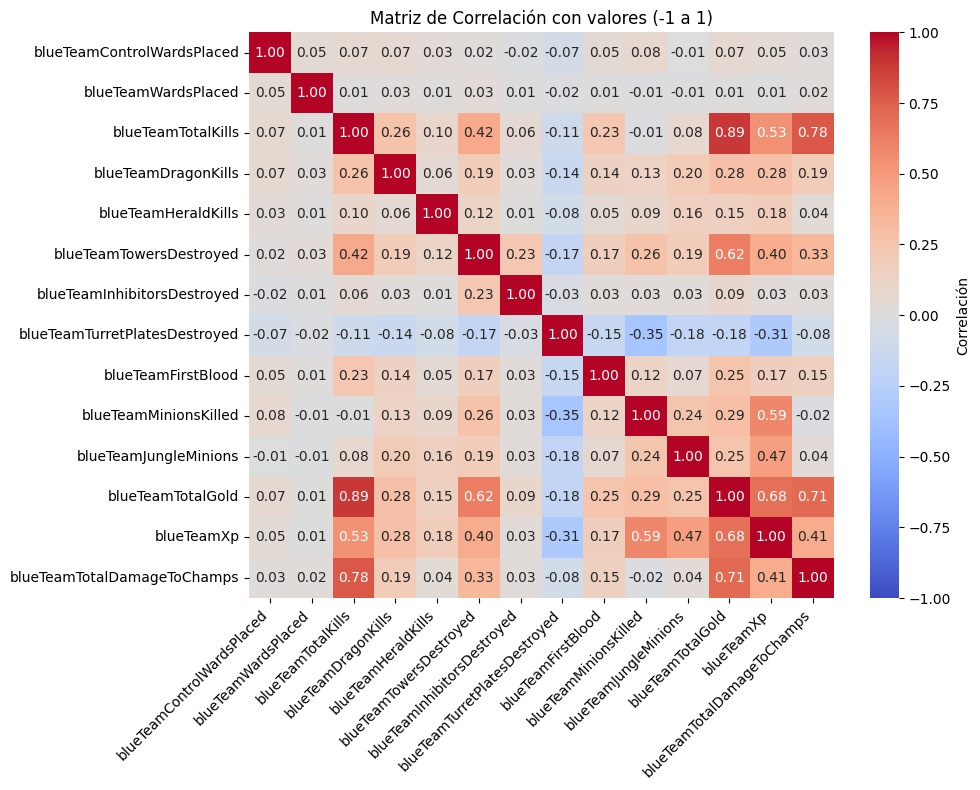

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular matriz de correlación
corr_matrix = df_clean.corr()

# Crear un mapa de calor con valores numéricos
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_clean.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlación"}
)
plt.title("Matriz de Correlación con valores (-1 a 1)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 1.2. VIF

=== Variance Inflation Factor of all variables ===
blueTeamTotalGold                14.108331
blueTeamTotalKills               11.571727
blueTeamXp                        3.649481
blueTeamMinionsKilled             2.934376
blueTeamTotalDamageToChamps       2.611408
blueTeamTowersDestroyed           2.101417
blueTeamJungleMinions             1.613710
blueTeamTurretPlatesDestroyed     1.204546
blueTeamDragonKills               1.142599
blueTeamFirstBlood                1.095787
blueTeamInhibitorsDestroyed       1.063459
blueTeamHeraldKills               1.052705
blueTeamControlWardsPlaced        1.025987
blueTeamWardsPlaced               1.006099
Name: VIF, dtype: float64


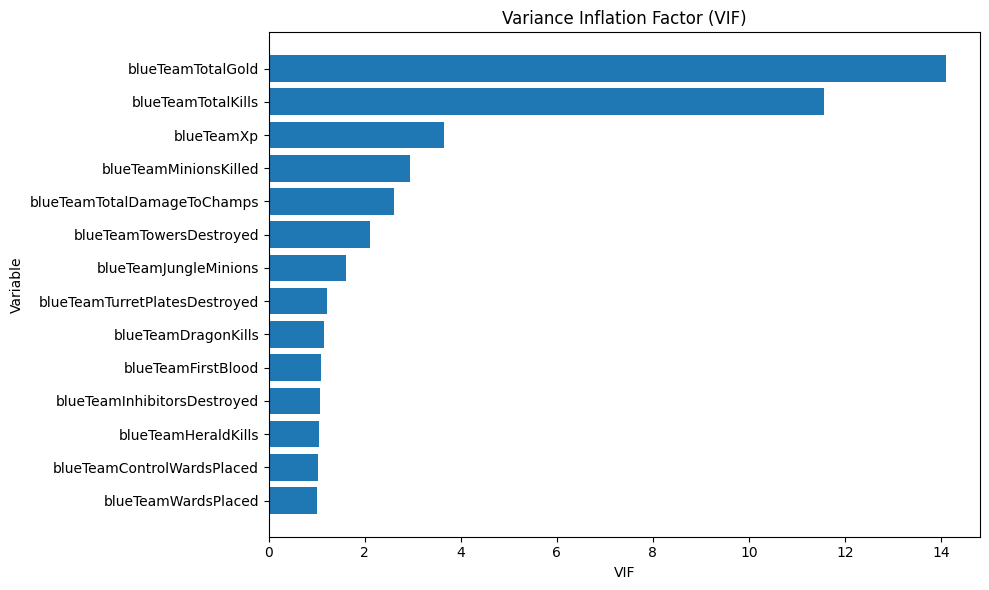

In [24]:
import numpy as np

vifs = pd.Series(np.linalg.inv(df_clean.corr().to_numpy()).diagonal(),
                 index=df_clean.columns,
                 name='VIF').sort_values(ascending=False)

# Mostrar tabla ordenada
print("=== Variance Inflation Factor of all variables ===")
print(vifs)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(vifs.index, vifs.values)
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Variance Inflation Factor (VIF)")
plt.xlabel("VIF")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

## 2. Generación de modelos

Antes de generar los modelos, tenemos que procesar un poco el dataframe y definir algunas variables.

In [15]:
from sklearn.model_selection import train_test_split

target_col = 'blueTeamTotalGold'

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

metrics = {"Model": [], "Set": [], "MSE": [], "RMSE": [], "MAE": [], "R2": []}
predictions = {}

### 2.1. Creación de modelos

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

tree_model = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid={
        'max_depth': [2, 3, 4, 5, 8, 10, None]
    }
)

forest_model = RandomForestRegressor(
    n_estimators=300,        # más árboles ayuda a estabilizar
    max_depth=10,            # limita profundidad
    min_samples_split=5,     # mínimo de 5 muestras para dividir
    min_samples_leaf=4,      # mínimo de 4 hojas por nodo
    max_features='sqrt',     # usa solo una parte de las variables por división
    random_state=42,
    n_jobs=-1                # usa todos los núcleos
)

models = {
    'Lasso': lasso_model,
    'DecisionTreeRegressor': tree_model,
    'RandomForestRegressor': forest_model
}

### 2.2. Entrenamiento de modelos

In [17]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predictions[name] = (y_train_pred, y_test_pred)

    # Métricas
    for set_name, y_true, y_pred in [("Train", y_train, y_train_pred), ("Test", y_test, y_test_pred)]:
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        metrics["Model"].append(name)
        metrics["Set"].append(set_name)
        metrics["MSE"].append(mse)
        metrics["RMSE"].append(rmse)
        metrics["MAE"].append(mae)
        metrics["R2"].append(r2)

In [18]:
print(f"Profundidad real del árbol: {models['DecisionTreeRegressor'].best_estimator_.max_depth} niveles")

Profundidad real del árbol: 8 niveles


### 2.3. Métricas de los modelos

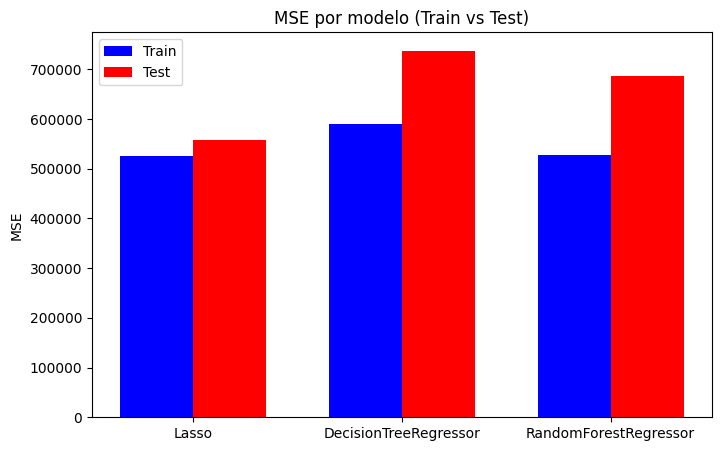

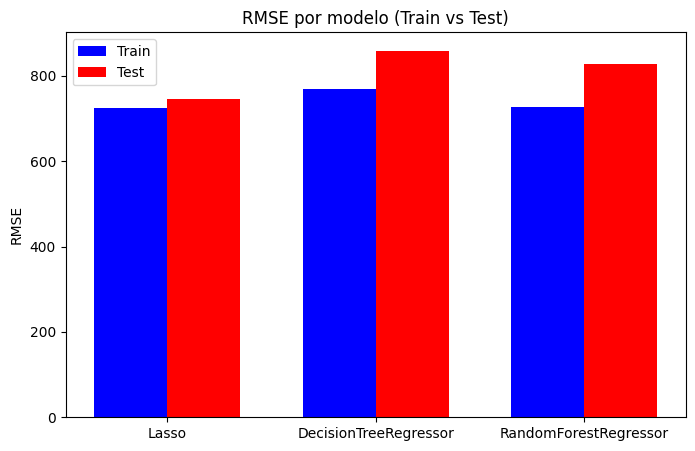

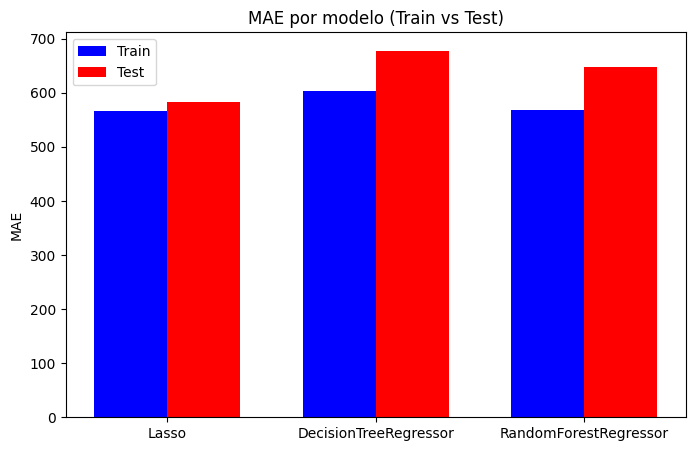

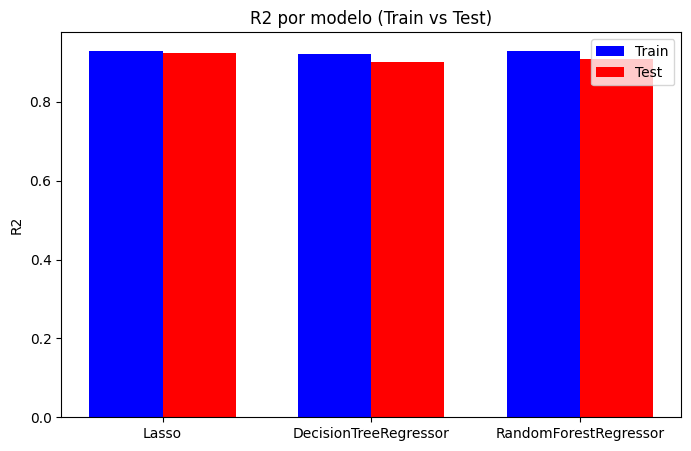

In [19]:
# Crear DataFrame de métricas
df_metrics = pd.DataFrame(metrics)
df_metrics.head(n=6)

# Mostrar gráficos por métrica
metric_names = ["MSE", "RMSE", "MAE", "R2"]
for metric in metric_names:
    plt.figure(figsize=(8, 5))
    train_data = df_metrics[df_metrics['Set'] == 'Train']
    test_data = df_metrics[df_metrics['Set'] == 'Test']

    plt.bar(np.arange(len(models)) + 0*0.35, train_data[metric], width=0.35, label='Train', color='b')
    plt.bar(np.arange(len(models)) + 1*0.35, test_data[metric], width=0.35, label='Test', color='r')

    plt.xticks(np.arange(len(models)) + 0.35/2, models.keys())
    plt.title(f"{metric} por modelo (Train vs Test)")
    plt.ylabel(metric)
    plt.legend()
    plt.show()



## 3. Información de los modelos

### 3.1. Visualización del árbol

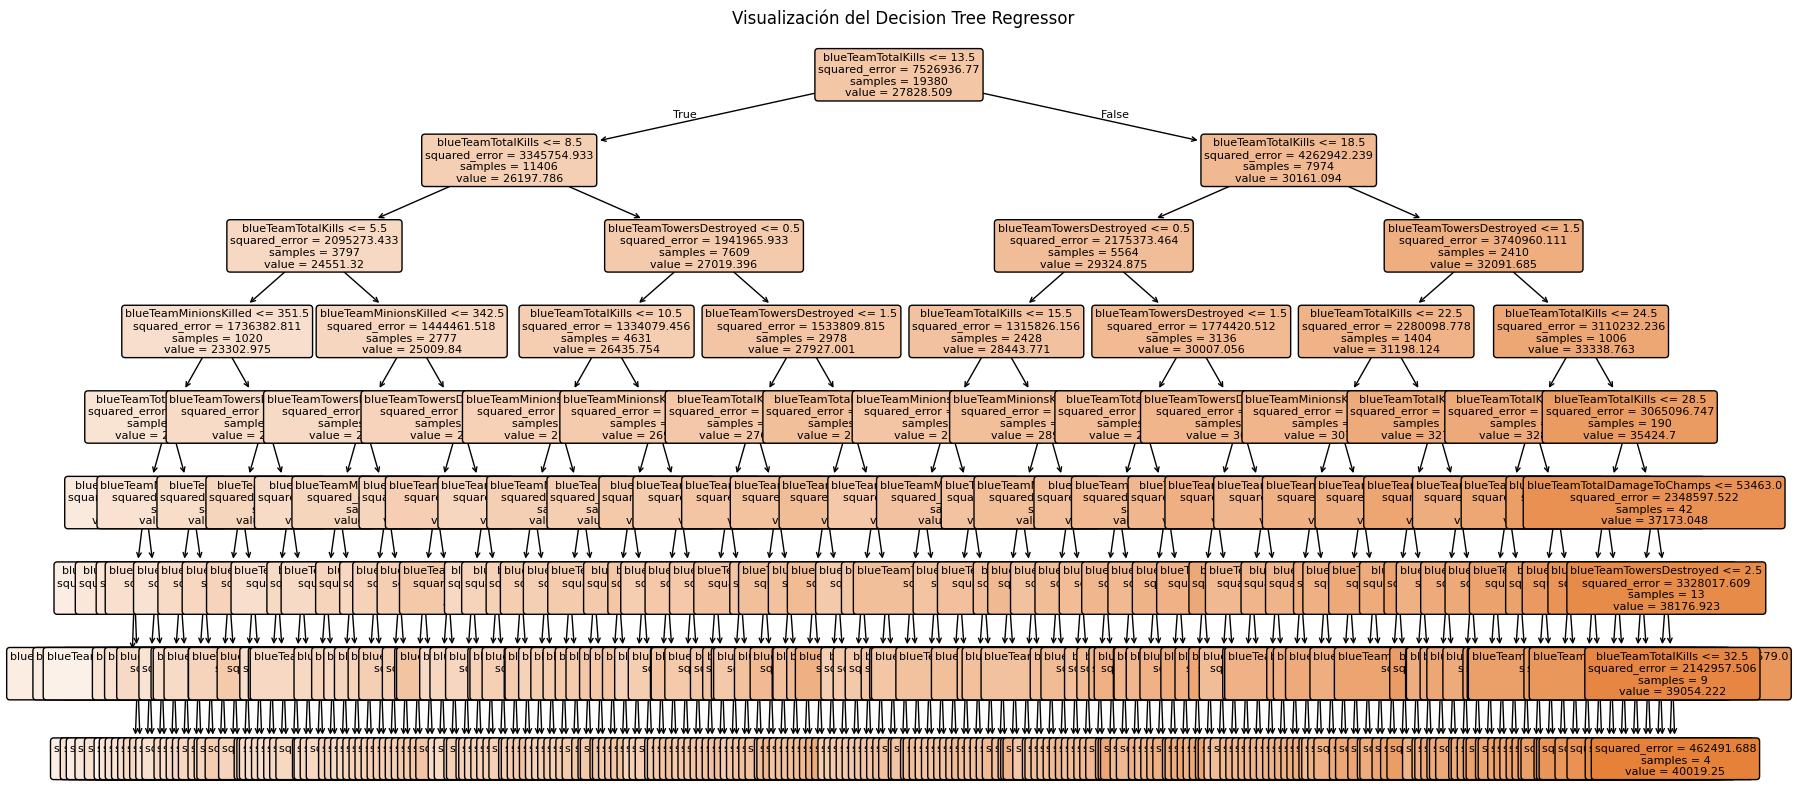

In [20]:
from sklearn.tree import plot_tree

# Generar gráficos de los árboles
plt.figure(figsize=(20, 10))
plot_tree(
    models['DecisionTreeRegressor'].best_estimator_,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=4 if models['DecisionTreeRegressor'].best_estimator_.max_depth > 10 else None  # limitar visualización para el árbol
)
plt.title(f"Visualización del Decision Tree Regressor")
plt.show()

### 3.2. Feature importance

#### 3.2.1. Decision Tree Regressor

=== Importancia de Variables (Decision Tree Regressor) ===
                         Variable  Importancia
2              blueTeamTotalKills     0.830970
5         blueTeamTowersDestroyed     0.104164
9           blueTeamMinionsKilled     0.052336
10          blueTeamJungleMinions     0.005630
11                     blueTeamXp     0.005546
12    blueTeamTotalDamageToChamps     0.000834
7   blueTeamTurretPlatesDestroyed     0.000186
1             blueTeamWardsPlaced     0.000115
6     blueTeamInhibitorsDestroyed     0.000080
4             blueTeamHeraldKills     0.000075
0      blueTeamControlWardsPlaced     0.000064
3             blueTeamDragonKills     0.000000
8              blueTeamFirstBlood     0.000000


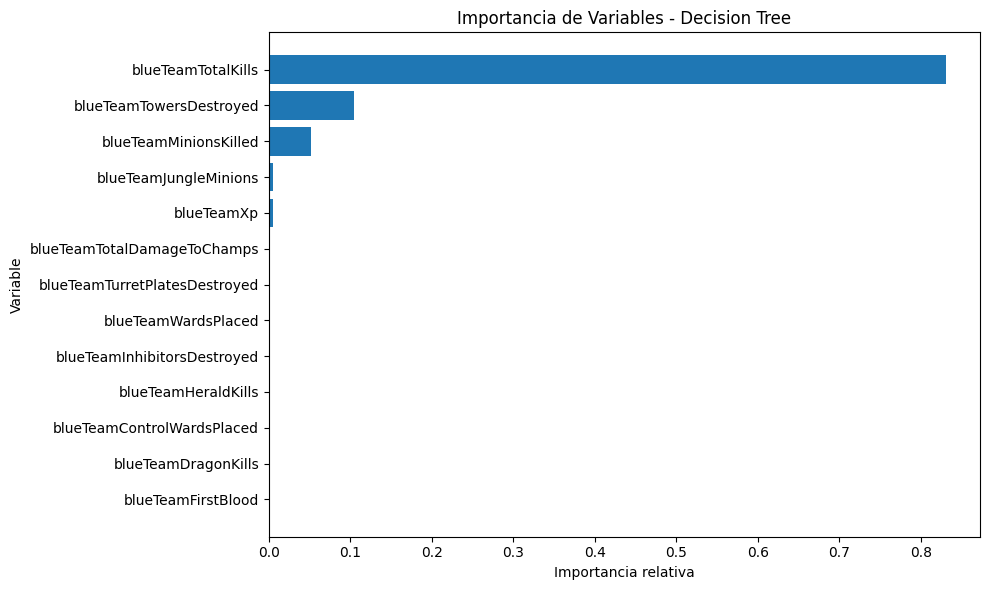

In [21]:
# Importancia de variables (Feature Importance)
importances = models['DecisionTreeRegressor'].best_estimator_.feature_importances_
features = X.columns

# Crear DataFrame ordenado
df_importances = pd.DataFrame({
    "Variable": features,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# Mostrar tabla ordenada
print("=== Importancia de Variables (Decision Tree Regressor) ===")
print(df_importances)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_importances["Variable"], df_importances["Importancia"])
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Importancia de Variables - Decision Tree")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

#### 3.2.2. Random Forest Regressor

=== Importancia de Variables (Random Forest Regressor) ===
                         Variable  Importancia
2              blueTeamTotalKills     0.440034
12    blueTeamTotalDamageToChamps     0.174155
11                     blueTeamXp     0.154216
5         blueTeamTowersDestroyed     0.148311
9           blueTeamMinionsKilled     0.031782
10          blueTeamJungleMinions     0.014002
8              blueTeamFirstBlood     0.013983
3             blueTeamDragonKills     0.010002
7   blueTeamTurretPlatesDestroyed     0.004308
1             blueTeamWardsPlaced     0.003540
4             blueTeamHeraldKills     0.002601
0      blueTeamControlWardsPlaced     0.002308
6     blueTeamInhibitorsDestroyed     0.000757


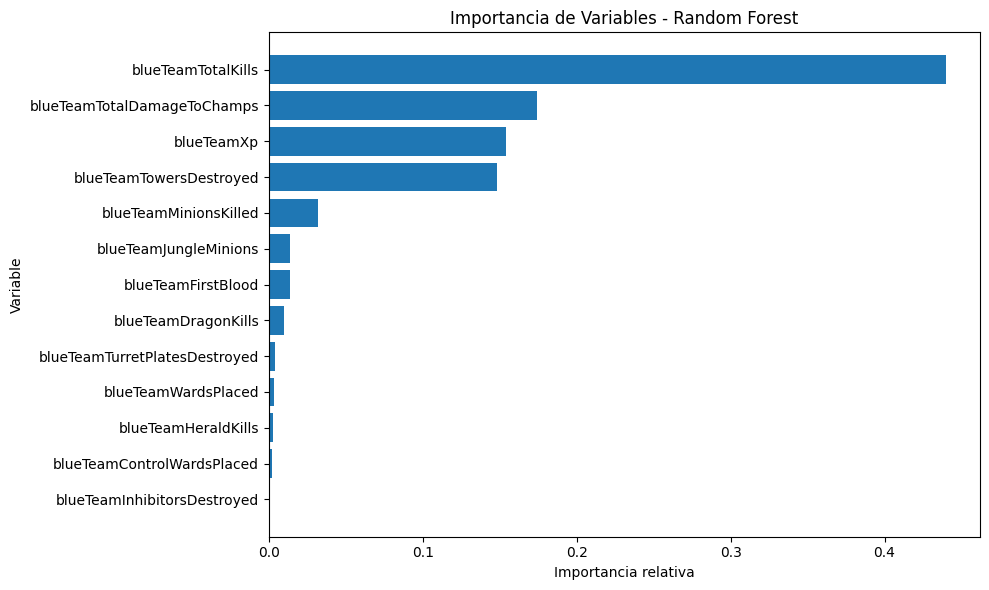

In [22]:
# Importancia de variables (Feature Importance)
importances = models['RandomForestRegressor'].feature_importances_
features = X.columns

# Crear DataFrame ordenado
df_importances = pd.DataFrame({
    "Variable": features,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# Mostrar tabla ordenada
print("=== Importancia de Variables (Random Forest Regressor) ===")
print(df_importances)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_importances["Variable"], df_importances["Importancia"])
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Importancia de Variables - Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

### 3.3. Pesos de la regresión Lasso

=== Coeficientes de Variables (Lasso Regression) ===
                         Variable  Coeficientes
2              blueTeamTotalKills   2032.431415
9           blueTeamMinionsKilled    609.609174
5         blueTeamTowersDestroyed    600.889441
10          blueTeamJungleMinions    270.734459
12    blueTeamTotalDamageToChamps    181.438528
7   blueTeamTurretPlatesDestroyed    102.098689
4             blueTeamHeraldKills     52.326946
11                     blueTeamXp     27.462340
8              blueTeamFirstBlood     25.446676
1             blueTeamWardsPlaced      3.786775
0      blueTeamControlWardsPlaced     -2.701802
6     blueTeamInhibitorsDestroyed    -26.926253
3             blueTeamDragonKills    -55.900487


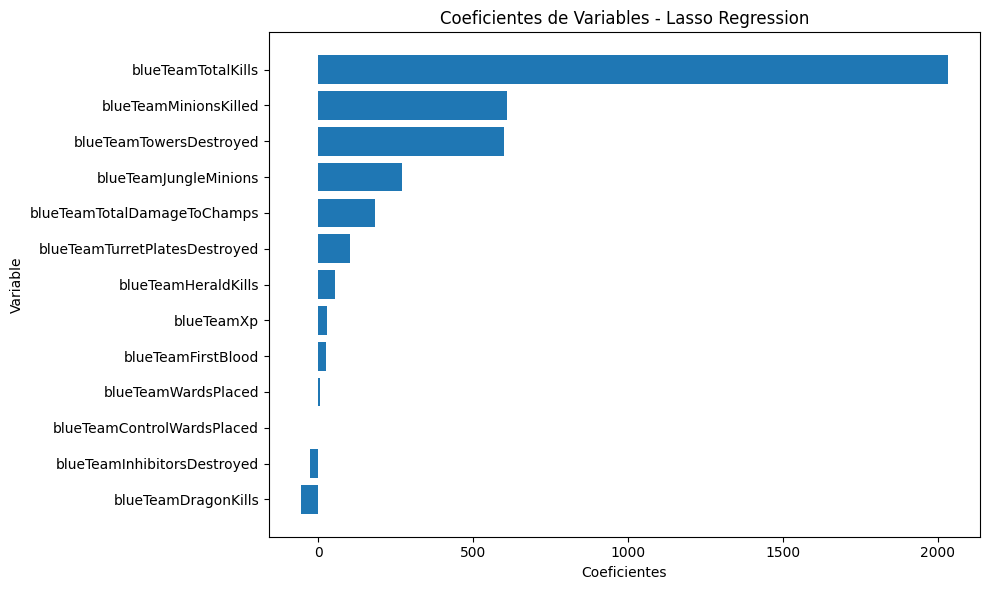

In [23]:
# Crear DataFrame ordenado
df_coefs = pd.DataFrame({
    "Variable": list(X.columns),
    "Coeficientes": models['Lasso'].named_steps['lasso'].coef_
}).sort_values(by="Coeficientes", ascending=False)

# Mostrar tabla ordenada
print("=== Coeficientes de Variables (Lasso Regression) ===")
print(df_coefs)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_coefs["Variable"], df_coefs["Coeficientes"])
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Coeficientes de Variables - Lasso Regression")
plt.xlabel("Coeficientes")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

